<a href="https://colab.research.google.com/github/Veldora00/Veldora00/blob/main/macro_corelation_change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HTTP error occurred: 400 Client Error: Bad Request for url: https://api.stlouisfed.org/fred/series/observations?series_id=ISM_MAN_PMI&api_key=1914a7e8b0b38709c172004439e86d0a&file_type=json
Failed to download data for ISM_MAN_PMI.
HTTP error occurred: 400 Client Error: Bad Request for url: https://api.stlouisfed.org/fred/series/observations?series_id=ADP_EMP&api_key=1914a7e8b0b38709c172004439e86d0a&file_type=json
Failed to download data for ADP_EMP.
Significant Relationships Between Macroeconomic Indicators:
    early_indicator late_indicator  correlation       p_value      slope  \
0          CPIAUCSL         UNRATE    -0.227046  8.570341e-05 -10.536840   
1          CPIAUCSL            GDP     0.480426  6.354540e-07   2.418000   
2          CPIAUCSL         PPIACO     0.762805  3.137960e-57   3.054854   
3          CPIAUCSL       FEDFUNDS     0.350722  6.186754e-10  22.734582   
4          CPIAUCSL         PAYEMS     0.253647  1.068523e-05   0.702577   
..              ...           

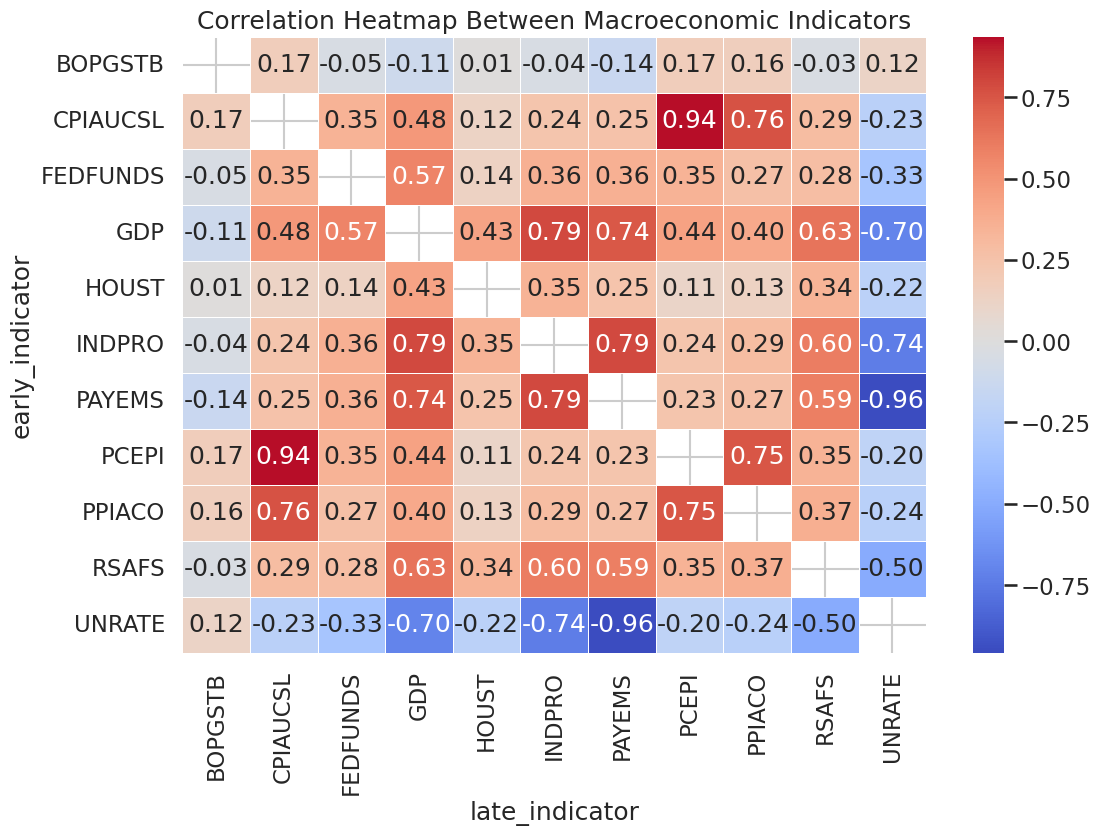

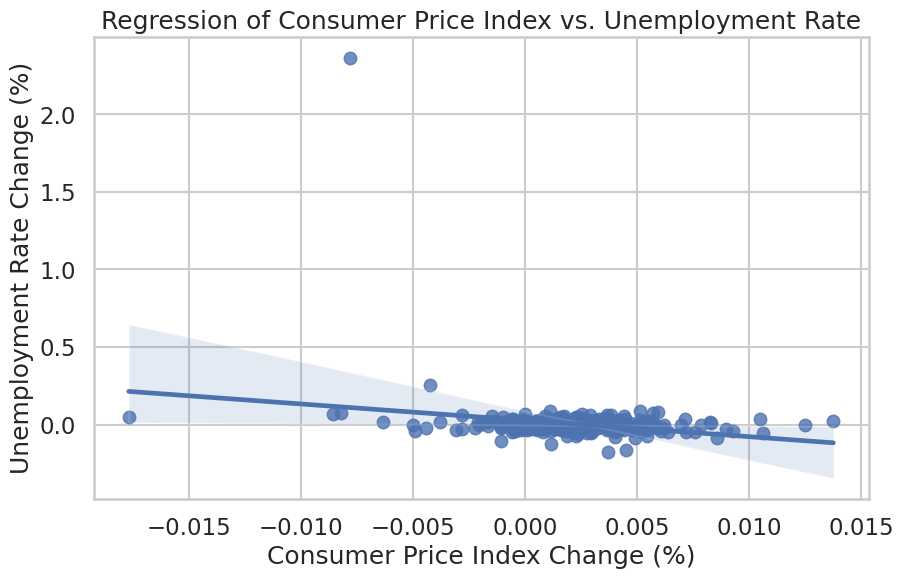

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import requests

# Enhanced visualization settings
sns.set(style="whitegrid", context="talk")

# Function to download macroeconomic data from FRED
def download_fred_data(series_id, api_key):
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json'
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        if 'observations' in data:
            observations = data['observations']
            df = pd.DataFrame(observations)
            df['date'] = pd.to_datetime(df['date'])
            df.set_index('date', inplace=True)
            df[series_id] = pd.to_numeric(df['value'].str.replace(',', ''), errors='coerce')
            df.drop(columns=['value', 'realtime_start', 'realtime_end'], inplace=True)
            return df
        else:
            print(f"Error: 'observations' key not found in response for {series_id}. Check API response.")
            return None
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except Exception as err:
        print(f"Other error occurred: {err}")
    return None

# Use your FRED API key
fred_api_key = 'x'

# Define macroeconomic indicators, including ISM and ADP
macro_indicators = {
    'CPIAUCSL': 'Consumer Price Index',
    'UNRATE': 'Unemployment Rate',
    'GDP': 'Gross Domestic Product',
    'PPIACO': 'Producer Price Index',
    'FEDFUNDS': 'Federal Funds Rate',
    'PAYEMS': 'Nonfarm Payrolls',
    'PCEPI': 'Personal Consumption Expenditures Price Index',
    'RSAFS': 'Retail Sales',
    'INDPRO': 'Industrial Production',
    'HOUST': 'Housing Starts',
    'BOPGSTB': 'Goods Trade Balance',
    # Adding ISM Manufacturing Index and ADP Employment Report
    'ISM_MAN_PMI': 'ISM Manufacturing Index',  # Replace 'ISM_MAN_PMI' with the correct FRED ID if available
    'ADP_EMP': 'ADP Employment Report'  # Replace 'ADP_EMP' with the correct FRED ID if available
}

# Dictionary to store thresholds for each indicator
thresholds_summary = {}

# Placeholder for storing all macroeconomic data
macro_data_combined = {}

# Download and process each macroeconomic indicator
for indicator, name in macro_indicators.items():
    macro_data = download_fred_data(indicator, fred_api_key)
    if macro_data is not None:
        macro_data = macro_data[macro_data.index >= '2000-01-01']
        macro_data['change'] = macro_data[indicator].pct_change()
        macro_data_combined[indicator] = macro_data
    else:
        print(f"Failed to download data for {indicator}.")

# Analyze relationships between indicators
all_reactions = []

for ind_early in macro_indicators:
    for ind_late in macro_indicators:
        if ind_early == ind_late:
            continue

        early_data = macro_data_combined.get(ind_early)
        late_data = macro_data_combined.get(ind_late)

        if early_data is None or late_data is None:
            continue

        # Align data on the monthly level
        early_data_monthly = early_data.resample('M').last()
        late_data_monthly = late_data.resample('M').last()

        # Merge early and late data
        merged_data = pd.merge(early_data_monthly[['change']], late_data_monthly[['change']],
                               left_index=True, right_index=True, suffixes=('_early', '_late'))

        # Record the reaction of the late indicator to the early indicator
        reaction_data = merged_data.dropna()
        slope, intercept, r_value, p_value, std_err = linregress(reaction_data['change_early'], reaction_data['change_late'])

        reaction_summary = {
            'early_indicator': ind_early,
            'late_indicator': ind_late,
            'correlation': r_value,
            'p_value': p_value,
            'slope': slope,
            'intercept': intercept
        }

        all_reactions.append(reaction_summary)

# Convert to DataFrame
reaction_df = pd.DataFrame(all_reactions)

# Filter significant correlations
significant_reactions = reaction_df[reaction_df['p_value'] < 0.05]

# Display significant reactions
print("Significant Relationships Between Macroeconomic Indicators:")
print(significant_reactions)

# Visualizing the relationships with a heatmap
heatmap_data = reaction_df.pivot(index='early_indicator', columns='late_indicator', values='correlation')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap Between Macroeconomic Indicators')
plt.show()

# Plot regression for one of the significant pairs
if not significant_reactions.empty:
    significant_pair = significant_reactions.iloc[0]
    early_indicator = significant_pair['early_indicator']
    late_indicator = significant_pair['late_indicator']

    early_data = macro_data_combined[early_indicator].resample('M').last()
    late_data = macro_data_combined[late_indicator].resample('M').last()

    merged_data = pd.merge(early_data[['change']], late_data[['change']],
                           left_index=True, right_index=True, suffixes=('_early', '_late'))

    # Perform regression analysis
    x = merged_data['change_early']
    y = merged_data['change_late']

    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Plot regression
    plt.figure(figsize=(10, 6))
    sns.regplot(x=x, y=y)
    plt.title(f'Regression of {macro_indicators[early_indicator]} vs. {macro_indicators[late_indicator]}')
    plt.xlabel(f'{macro_indicators[early_indicator]} Change (%)')
    plt.ylabel(f'{macro_indicators[late_indicator]} Change (%)')
    plt.show()
else:
    print("No significant relationships found between the macroeconomic indicators.")